# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('data/zillow_data.csv')

In [3]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


# Step 2: Data Preprocessing

In [5]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')

In [6]:
datetimes = get_datetimes(df)

In [7]:
datetimes

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

In [26]:
date_dict = {}
for key, value in list(zip(df.columns[7:], datetimes)):
    date_dict[key] = value

In [27]:
df.rename(columns=date_dict)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,...,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


# Step 3: EDA and Visualization

In [8]:
#font = {'family' : 'normal',
#        'weight' : 'bold',
#        'size'   : 22}
#
#matplotlib.rc('font', **font)
#
# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [28]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [31]:
df['total_increase'] = df['2018-04'] - df['1996-04']
df['ten_year_increase'] = df['2018-04'] - df['2008-04']
df['five_year_increase'] = df['2018-04'] - df['2013-04']

In [74]:
total_increase_top_ten = df.sort_values('total_increase', ascending=False)[:10]
ten_year_increase_top_ten = df.sort_values('ten_year_increase', ascending=False)[:10]
five_year_increase_top_ten = df.sort_values('five_year_increase', ascending=False)[:10]

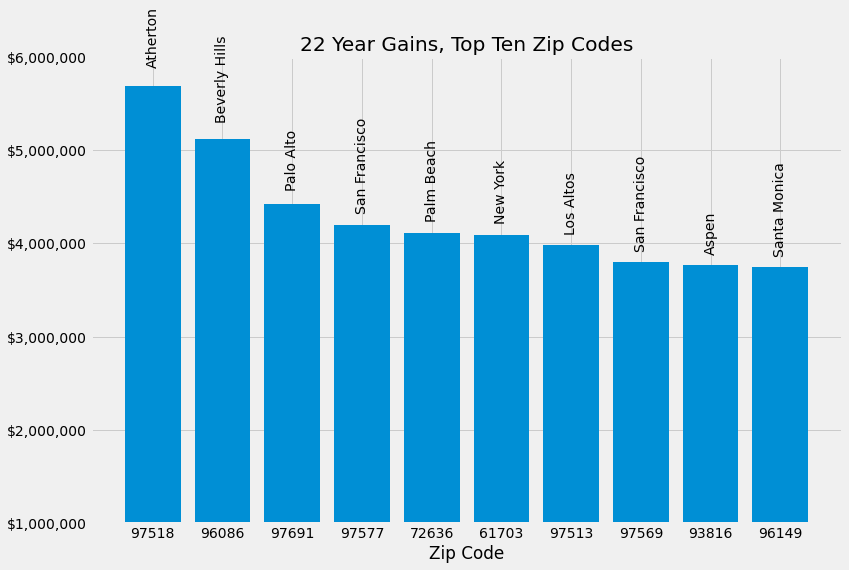

In [91]:
fig, ax = plt.subplots(figsize=(12,8))
bar = ax.bar(total_increase_top_ten.RegionID.astype('str'), total_increase_top_ten.total_increase)
ax.set_title('22 Year Gains, Top Ten Zip Codes')
ax.set_xlabel('Zip Code')
ax.set_yticks(np.linspace(0, 6000000, 6))
ax.set_yticklabels(['$1,000,000','$2,000,000','$3,000,000','$4,000,000','$5,000,000','$6,000,000'])
for i, rect in enumerate(bar):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            total_increase_top_ten.City.values[i], ha='center', rotation='vertical');

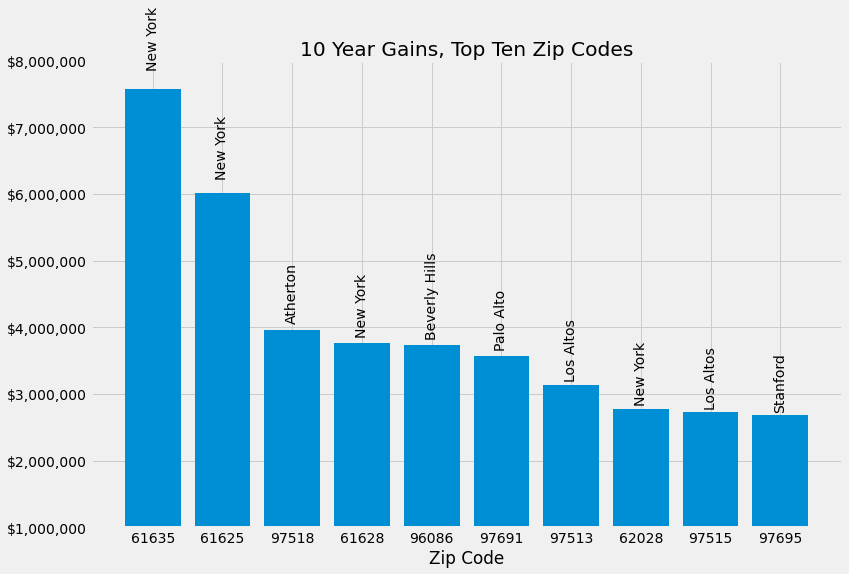

In [100]:
fig, ax = plt.subplots(figsize=(12,8))
bar = ax.bar(ten_year_increase_top_ten.RegionID.astype('str'), ten_year_increase_top_ten.ten_year_increase)
ax.set_title('10 Year Gains, Top Ten Zip Codes')
ax.set_xlabel('Zip Code')
ax.set_yticks(np.linspace(0, 8000000, 8))
ax.set_yticklabels(['$1,000,000','$2,000,000','$3,000,000','$4,000,000','$5,000,000','$6,000,000',
                   '$7,000,000', '$8,000,000'])
for i, rect in enumerate(bar):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            ten_year_increase_top_ten.City.values[i], ha='center', rotation='vertical');

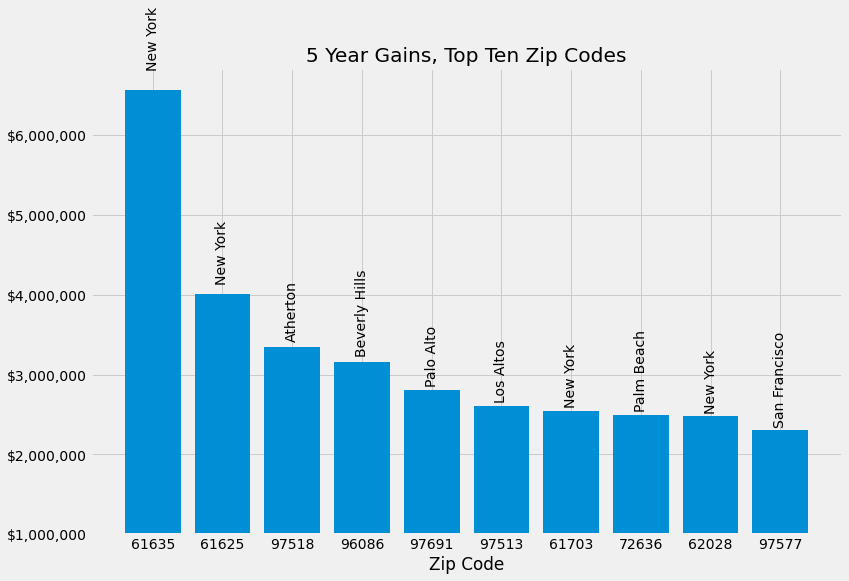

In [101]:
fig, ax = plt.subplots(figsize=(12,8))
bar = ax.bar(five_year_increase_top_ten.RegionID.astype('str'), five_year_increase_top_ten.five_year_increase)
ax.set_title('5 Year Gains, Top Ten Zip Codes')
ax.set_xlabel('Zip Code')
ax.set_yticks(np.linspace(0, 6000000, 6))
ax.set_yticklabels(['$1,000,000','$2,000,000','$3,000,000','$4,000,000','$5,000,000','$6,000,000'])
for i, rect in enumerate(bar):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            five_year_increase_top_ten.City.values[i], ha='center', rotation='vertical');

# Step 4: Reshape from Wide to Long Format

In [9]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 
                                  'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted#.groupby('time').aggregate({'value':'mean'})

In [10]:
melted = melt_data(df)

In [11]:
melted.head()

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,time,value
0,60657,84654,1,Chicago,IL,Chicago,Cook,1996-04-01,334200.0
1,75070,90668,2,McKinney,TX,Dallas-Fort Worth,Collin,1996-04-01,235700.0
2,77494,91982,3,Katy,TX,Houston,Harris,1996-04-01,210400.0
3,60614,84616,4,Chicago,IL,Chicago,Cook,1996-04-01,498100.0
4,79936,93144,5,El Paso,TX,El Paso,El Paso,1996-04-01,77300.0


In [12]:
melted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3744704 entries, 0 to 3901594
Data columns (total 9 columns):
 #   Column      Dtype         
---  ------      -----         
 0   RegionName  int64         
 1   RegionID    int64         
 2   SizeRank    int64         
 3   City        object        
 4   State       object        
 5   Metro       object        
 6   CountyName  object        
 7   time        datetime64[ns]
 8   value       float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 285.7+ MB


In [13]:
melted.set_index('time', inplace=True)

In [14]:
melted.head()

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,value
time,,,,,,,,
1996-04-01,60657,84654,1,Chicago,IL,Chicago,Cook,334200.0
1996-04-01,75070,90668,2,McKinney,TX,Dallas-Fort Worth,Collin,235700.0
1996-04-01,77494,91982,3,Katy,TX,Houston,Harris,210400.0
1996-04-01,60614,84616,4,Chicago,IL,Chicago,Cook,498100.0
1996-04-01,79936,93144,5,El Paso,TX,El Paso,El Paso,77300.0


In [15]:
frostburg = melted[melted.RegionName == 21532]

<AxesSubplot:xlabel='time'>

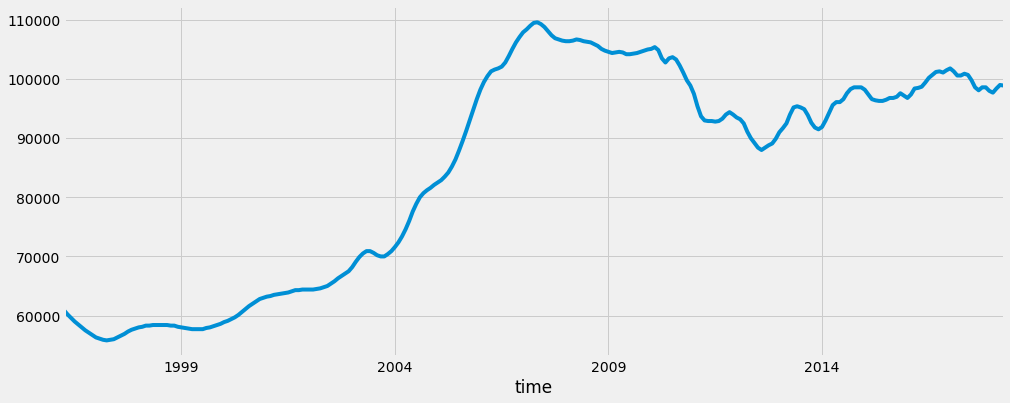

In [19]:
frostburg.value.plot(figsize=(15,6))

# Step 5: ARIMA Modeling

# Step 6: Interpreting Results